# Description:

* For emperical data, most taxa (>0.1% abundance) are detected across the entire gradient.
* Checking whether a similar pattern is seen with the simulated genome data

# Setting variables

In [1]:
workDir = '/home/nick/notebook/SIPSim/dev/bac_genome3/validation/'
R_dir = '/home/nick/notebook/SIPSim/lib/R/'
figDir = '/home/nick/notebook/SIPSim/figures/'

nprocs = 3

# Init

In [2]:
import os
import numpy as np
import dill
import pandas as pd
%load_ext rpy2.ipython

In [3]:
%%R
library(ggplot2)
library(plyr)
library(dplyr)
library(tidyr)
library(gridExtra)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [4]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)

## Determining the probability of detecting the taxa across the entire gradient

In [5]:
# max 13C shift
max_13C_shift_in_BD = 0.036
# min BD (that we care about)
min_GC = 13.5
min_BD = min_GC/100.0 * 0.098 + 1.66
# max BD (that we care about)
max_GC = 80
max_BD = max_GC / 100.0 * 0.098 + 1.66    # 80.0% G+C
max_BD = max_BD + max_13C_shift_in_BD
## BD range of values
BD_vals = np.arange(min_BD, max_BD, 0.001)

### skewed normal distribution

In [6]:
F = os.path.join(workDir, 'ampFrags_real_kde_dif.pkl')
with open(F, 'rb') as inFH:
    kde = dill.load(inFH)
kde

{'Clostridium_ljungdahlii_DSM_13528': <scipy.stats.kde.gaussian_kde at 0x7f8f77b71e10>,
 'Escherichia_coli_1303': <scipy.stats.kde.gaussian_kde at 0x7f8f6c5caf90>,
 'Streptomyces_pratensis_ATCC_33331': <scipy.stats.kde.gaussian_kde at 0x7f8f6c5da110>}

In [7]:
# probability at each location in gradient
pdf = {}
for k,v in kde.items():
    pdf[k] = v.evaluate(BD_vals)
pdf.keys()

['Clostridium_ljungdahlii_DSM_13528',
 'Escherichia_coli_1303',
 'Streptomyces_pratensis_ATCC_33331']

In [8]:
df = pd.DataFrame(pdf)
df['BD'] = BD_vals
df.head(n=3)

,Clostridium_ljungdahlii_DSM_13528,Escherichia_coli_1303,Streptomyces_pratensis_ATCC_33331,BD
0,0.001243,0.000911,1.124326e-23,1.67323
1,0.001323,0.001018,2.419102e-29,1.67423
2,0.000962,0.000035,1.021052e-35,1.67523


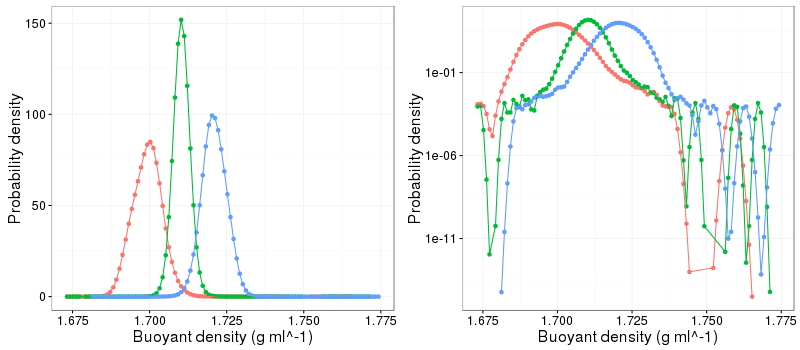

In [17]:
%%R -i df -w 800 -h 350

df.g = apply(df, 2, as.numeric) %>% as.data.frame %>%
    gather(taxon_name, P, 1:3) %>%
    mutate(BD = as.numeric(BD),
           P = as.numeric(P),
           taxon_name = as.character(taxon_name)) %>%
    filter(P > 1e-15)


p1 = ggplot(df.g, aes(BD, P, color=taxon_name)) +
    geom_point() +
    geom_line() +
    labs(x='Buoyant density (g ml^-1)', y='Probability density') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'none'
    )

p2 = p1 + scale_y_log10()

grid.arrange(p1, p2, ncol=2)

### small uniform distribution

In [45]:
F = os.path.join(workDir, 'ampFrags_sm_kde_dif.pkl')
with open(F, 'rb') as inFH:
    kde = dill.load(inFH)
kde

{'Clostridium_ljungdahlii_DSM_13528': <scipy.stats.kde.gaussian_kde at 0x7f57920002d0>,
 'Escherichia_coli_1303': <scipy.stats.kde.gaussian_kde at 0x7f5786a2ac50>,
 'Streptomyces_pratensis_ATCC_33331': <scipy.stats.kde.gaussian_kde at 0x7f5786775650>}

In [46]:
# probability at each location in gradient
pdf = {}
for k,v in kde.items():
    pdf[k] = v.evaluate(BD_vals)
pdf.keys()

['Clostridium_ljungdahlii_DSM_13528',
 'Escherichia_coli_1303',
 'Streptomyces_pratensis_ATCC_33331']

In [47]:
df = pd.DataFrame(pdf)
df['BD'] = BD_vals
df.head(n=3)

,Clostridium_ljungdahlii_DSM_13528,Escherichia_coli_1303,Streptomyces_pratensis_ATCC_33331,BD
0,7.857816e-09,1.369181e-86,1.211640e-210,1.67323
1,5.077048e-06,4.330080e-72,8.674757e-187,1.67423
2,2.742817e-04,5.570290e-59,2.156821e-164,1.67523


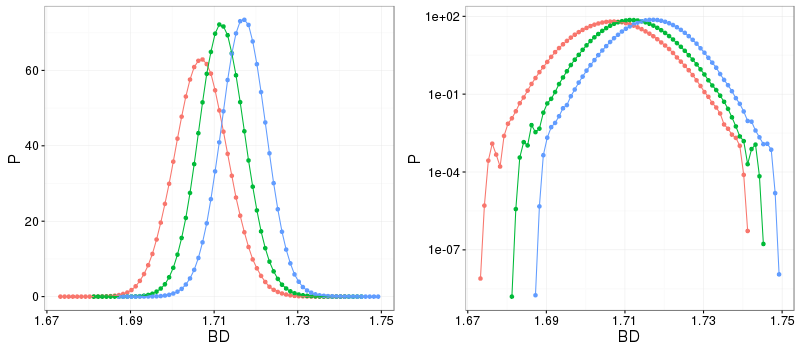

In [48]:
%%R -i df -w 800 -h 350

df.g = apply(df, 2, as.numeric) %>% as.data.frame %>%
    gather(taxon_name, P, 1:3) %>%
    mutate(BD = as.numeric(BD),
           P = as.numeric(P),
           taxon_name = as.character(taxon_name)) %>%
    filter(P > 1e-9)



p1 = ggplot(df.g, aes(BD, P, color=taxon_name)) +
    geom_point() +
    geom_line() +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'none'
    )

p2 = p1 + scale_y_log10()

grid.arrange(p1, p2, ncol=2)

#### Notes

* Even with fragment sizes of 1-2 kb, the taxa would likely not be detected even if the gradient contained 1e9 16S copies of the taxon.
  * Does this make sense based on the theory of diffusion used?

# with DBL 'smearing'

## Determining the probability of detecting in all fragments

### skewed normal distribution

In [21]:
BD_vals = np.arange(min_BD, max_BD, 0.001)

In [22]:
F = os.path.join(workDir, 'ampFrags_real_kde_dif_DBL.pkl')
with open(F, 'rb') as inFH:
    kde = dill.load(inFH)
kde

{'1': {'Clostridium_ljungdahlii_DSM_13528': <scipy.stats.kde.gaussian_kde at 0x7f8f6c5b5050>,
  'Escherichia_coli_1303': <scipy.stats.kde.gaussian_kde at 0x7f8f6bbf5950>,
  'Streptomyces_pratensis_ATCC_33331': <scipy.stats.kde.gaussian_kde at 0x7f8f6c5b5450>}}

In [26]:
# probability at each location in gradient
pdf = {}
for k,v in kde.items():
    for kk,vv in v.items():
        pdf[kk] = vv.evaluate(BD_vals)
pdf.keys()

['Clostridium_ljungdahlii_DSM_13528',
 'Escherichia_coli_1303',
 'Streptomyces_pratensis_ATCC_33331']

In [27]:
df = pd.DataFrame(pdf)
df['BD'] = BD_vals
df.head(n=3)

,Clostridium_ljungdahlii_DSM_13528,Escherichia_coli_1303,Streptomyces_pratensis_ATCC_33331,BD
0,0.010638,0.008191,0.005584,1.67323
1,0.011043,0.009031,0.004520,1.67423
2,0.010536,0.006191,0.003668,1.67523


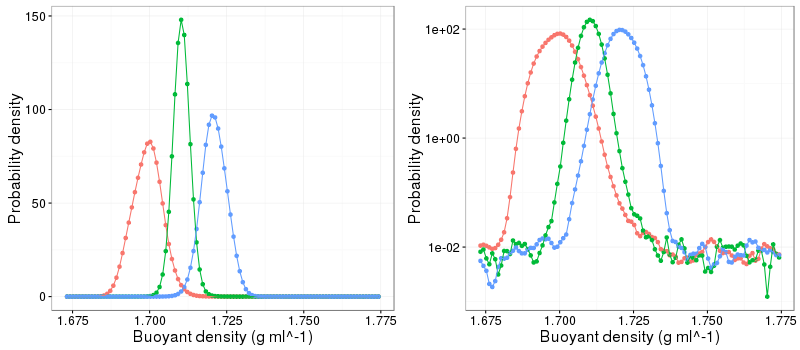

In [30]:
%%R -i df -w 800 -h 350

df.g = apply(df, 2, as.numeric) %>% as.data.frame %>%
    gather(taxon_name, P, 1:3) %>%
    mutate(BD = as.numeric(BD),
           P = as.numeric(P),
           taxon_name = as.character(taxon_name)) %>%
    filter(P > 1e-15)

p1 = ggplot(df.g, aes(BD, P, color=taxon_name)) +
    geom_point() +
    geom_line() +
    labs(x='Buoyant density (g ml^-1)', y='Probability density') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'none'
    )

p2 = p1 + scale_y_log10()

grid.arrange(p1, p2, ncol=2)

#### Notes

* Even if 1% of DNA is in DBL (that then diffuses back into the gradient):
  * the probably of detecting a taxa in all the gradient positions is >= 1e-7
    * this is feasible for matching the emperical data!

### small fragment size distribution

In [54]:
BD_vals = np.arange(min_BD, max_BD, 0.001)

In [55]:
F = os.path.join(workDir, 'ampFrags_sm_kde_dif_DBL.pkl')
with open(F, 'rb') as inFH:
    kde = dill.load(inFH)
kde

{'Clostridium_ljungdahlii_DSM_13528': <scipy.stats.kde.gaussian_kde at 0x7f5786775a90>,
 'Escherichia_coli_1303': <scipy.stats.kde.gaussian_kde at 0x7f5786a0e090>,
 'Streptomyces_pratensis_ATCC_33331': <scipy.stats.kde.gaussian_kde at 0x7f57867941d0>}

In [56]:
# probability at each location in gradient
pdf = {}
for k,v in kde.items():
    pdf[k] = v.evaluate(BD_vals)
pdf.keys()

['Clostridium_ljungdahlii_DSM_13528',
 'Escherichia_coli_1303',
 'Streptomyces_pratensis_ATCC_33331']

In [57]:
df = pd.DataFrame(pdf)
df['BD'] = BD_vals
df.head(n=3)

,Clostridium_ljungdahlii_DSM_13528,Escherichia_coli_1303,Streptomyces_pratensis_ATCC_33331,BD
0,0.003643,0.008033,0.008235,1.67323
1,0.004997,0.008003,0.007361,1.67423
2,0.008100,0.008035,0.007202,1.67523


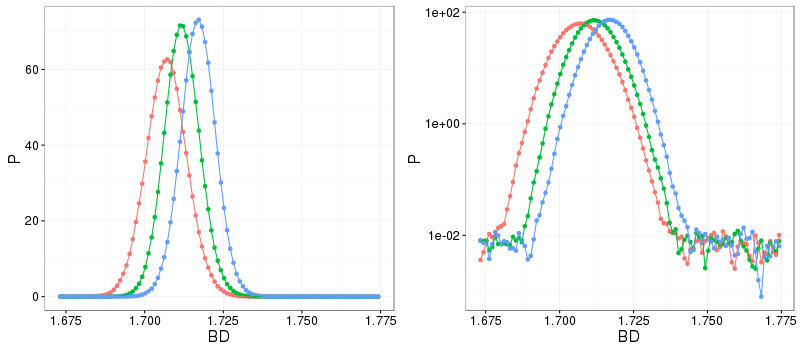

In [58]:
%%R -i df -w 800 -h 350

df.g = apply(df, 2, as.numeric) %>% as.data.frame %>%
    gather(taxon_name, P, 1:3) %>%
    mutate(BD = as.numeric(BD),
           P = as.numeric(P),
           taxon_name = as.character(taxon_name)) %>%
    filter(P > 1e-9)

p1 = ggplot(df.g, aes(BD, P, color=taxon_name)) +
    geom_point() +
    geom_line() +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'none'
    )

p2 = p1 + scale_y_log10()

grid.arrange(p1, p2, ncol=2)

# with DBL 'smearing' (smaller DBL)

## Determining the probability of detecting in all fragments

### skewed normal distribution

In [59]:
BD_vals = np.arange(min_BD, max_BD, 0.001)

In [60]:
F = os.path.join(workDir, 'ampFrags_real_kde_dif_DBL_fa1e-4.pkl')
with open(F, 'rb') as inFH:
    kde = dill.load(inFH)
kde

{'Clostridium_ljungdahlii_DSM_13528': <scipy.stats.kde.gaussian_kde at 0x7f5786775690>,
 'Escherichia_coli_1303': <scipy.stats.kde.gaussian_kde at 0x7f5786775f90>,
 'Streptomyces_pratensis_ATCC_33331': <scipy.stats.kde.gaussian_kde at 0x7f5786775c90>}

In [61]:
# probability at each location in gradient
pdf = {}
for k,v in kde.items():
    pdf[k] = v.evaluate(BD_vals)
pdf.keys()

['Clostridium_ljungdahlii_DSM_13528',
 'Escherichia_coli_1303',
 'Streptomyces_pratensis_ATCC_33331']

In [62]:
df = pd.DataFrame(pdf)
df['BD'] = BD_vals
df.head(n=3)

,Clostridium_ljungdahlii_DSM_13528,Escherichia_coli_1303,Streptomyces_pratensis_ATCC_33331,BD
0,1.631444e-06,0.000375,0.000216,1.67323
1,5.361316e-07,0.001505,0.001849,1.67423
2,3.456207e-04,0.002166,0.000028,1.67523


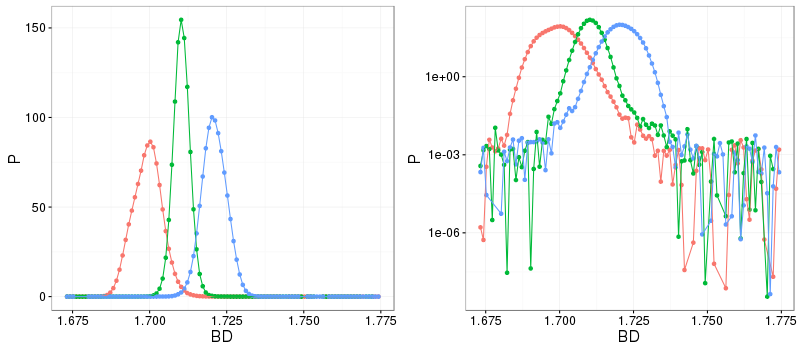

In [63]:
%%R -i df -w 800 -h 350

df.g = apply(df, 2, as.numeric) %>% as.data.frame %>%
    gather(taxon_name, P, 1:3) %>%
    mutate(BD = as.numeric(BD),
           P = as.numeric(P),
           taxon_name = as.character(taxon_name)) %>%
    filter(P > 1e-9)

p1 = ggplot(df.g, aes(BD, P, color=taxon_name)) +
    geom_point() +
    geom_line() +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'none'
    )

p2 = p1 + scale_y_log10()

grid.arrange(p1, p2, ncol=2)

# DBL with abundance-weighted smearing

In [131]:
BD_vals = np.arange(min_BD, max_BD, 0.001)

F = os.path.join(workDir, 'ampFrags_real_kde_dif_DBL-comm.pkl')
with open(F, 'rb') as inFH:
    kde = dill.load(inFH)
kde

{'1': {'Clostridium_ljungdahlii_DSM_13528': <scipy.stats.kde.gaussian_kde at 0x7f5786694390>,
  'Escherichia_coli_1303': <scipy.stats.kde.gaussian_kde at 0x7f5786a2a710>,
  'Streptomyces_pratensis_ATCC_33331': <scipy.stats.kde.gaussian_kde at 0x7f5786723490>}}

In [132]:
# probability at each location in gradient
pdf = {}
for libID,v in kde.items():
    for taxon,k in v.items():
        pdf[taxon] = k.evaluate(BD_vals)
pdf.keys()

['Clostridium_ljungdahlii_DSM_13528',
 'Escherichia_coli_1303',
 'Streptomyces_pratensis_ATCC_33331']

In [133]:
df = pd.DataFrame(pdf)
df['BD'] = BD_vals
df.head(n=3)

,Clostridium_ljungdahlii_DSM_13528,Escherichia_coli_1303,Streptomyces_pratensis_ATCC_33331,BD
0,1.691746,2.760888,1.230768,1.67323
1,1.699645,2.763073,1.213971,1.67423
2,1.706747,2.762859,1.197765,1.67523


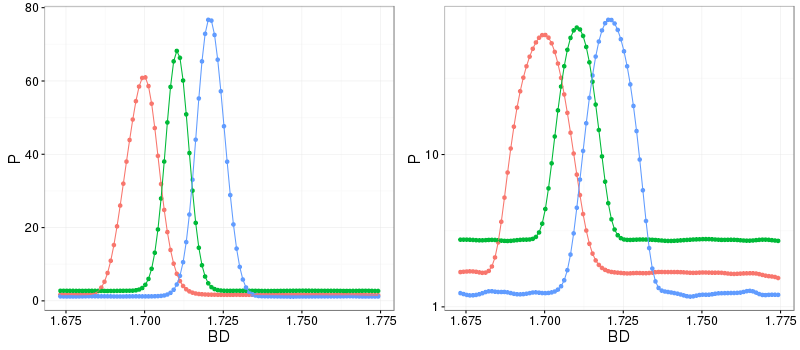

In [134]:
%%R -i df -w 800 -h 350

df.g = apply(df, 2, as.numeric) %>% as.data.frame %>%
    gather(taxon_name, P, 1:3) %>%
    mutate(BD = as.numeric(BD),
           P = as.numeric(P),
           taxon_name = as.character(taxon_name)) %>%
    filter(P > 1e-9)

p1 = ggplot(df.g, aes(BD, P, color=taxon_name)) +
    geom_point() +
    geom_line() +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'none'
    )

p2 = p1 + scale_y_log10()

grid.arrange(p1, p2, ncol=2)

In [135]:
%%R
df.g %>%
    group_by(taxon_name) %>%
    summarize(max_P = max(P),
              min_P = min(P)) %>% print

Source: local data frame [3 x 3]

                         taxon_name    max_P    min_P
                              (chr)    (dbl)    (dbl)
1 Clostridium_ljungdahlii_DSM_13528 60.98170 1.546809
2             Escherichia_coli_1303 68.20404 2.708163
3 Streptomyces_pratensis_ATCC_33331 76.69533 1.167650


### Plotting pre-frac abundance vs heavy fraction P

  library                        taxon_name rel_abund_perc rank rel_abund
1       1             Escherichia_coli_1303       48.87428    1 0.4887428
2       1 Clostridium_ljungdahlii_DSM_13528       29.55341    2 0.2955341
3       1 Streptomyces_pratensis_ATCC_33331       21.57231    3 0.2157231
Source: local data frame [3 x 6]

                         taxon_name   mean_P library rel_abund_perc  rank
                              (chr)    (dbl)   (int)          (dbl) (int)
1 Clostridium_ljungdahlii_DSM_13528 1.644610       1       29.55341     2
2             Escherichia_coli_1303 2.751454       1       48.87428     1
3 Streptomyces_pratensis_ATCC_33331 1.224158       1       21.57231     3
Variables not shown: rel_abund (dbl)


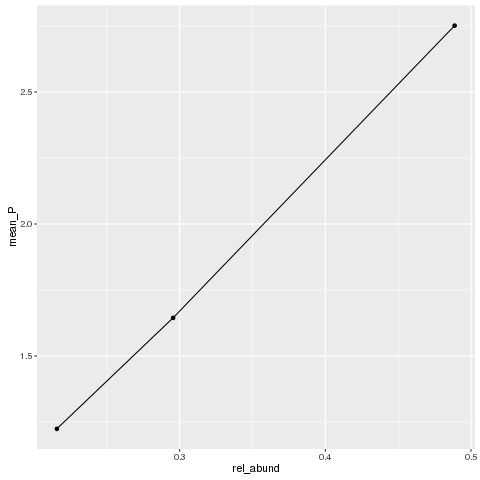

In [136]:
%%R -i workDir

F = file.path(workDir, 'comm.txt')
df.comm = read.delim(F, sep='\t') %>%
    mutate(rel_abund = rel_abund_perc / 100)
df.comm %>% print

df.g.s = df.g %>%
    filter(BD > 1.75) %>%
    group_by(BD) %>%
    mutate(P_rel_abund = P / sum(P)) %>%
    group_by(taxon_name) %>%
    summarize(mean_P = mean(P))

df.g.s = inner_join(df.g.s, df.comm, c('taxon_name' = 'taxon_name')) 
df.g.s %>% print

ggplot(df.g.s, aes(rel_abund, mean_P)) +
    geom_point() +
    geom_line()